In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Checking my Files

In [2]:
!ls /kaggle/input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [3]:
ls = os.listdir('/kaggle/input/planets-dataset/planet/planet/train-jpg')
no_of_files = len(ls)
print('The number of train files is: {}'.format(no_of_files))

ls = os.listdir('/kaggle/input/planets-dataset/planet/planet/test-jpg')
no_of_files = len(ls)
print('The number of test files is: {}'.format(no_of_files))

ls = os.listdir('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional')
no_of_files = len(ls)
print('The number of test_additional files is: {}'.format(no_of_files))

The number of train files is: 40479
The number of test files is: 40669
The number of test_additional files is: 20522


In [4]:
train = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
sample_sub = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')

train.shape, sample_sub.shape

((40479, 2), (61191, 2))

I will need to add the `test` and the `test-additional` files in order to get the total number of required files for submission. This can be viewed in the `sample_sub` dataset.

In [5]:
# importing the necessary libraries

import gc # garbage collector
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import fbeta_score
import time
%matplotlib inline


pal = sns.color_palette()

In [6]:
#Explore train labels distribution

labels = train['tags'].apply(lambda x: x.split(' '))

from collections import Counter, defaultdict
counts = defaultdict(int) #dictionary containing each individual label

for label in labels:
    for l in label:
        counts[l] += 1
        
tag_list = list(counts.keys())
tag_list

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

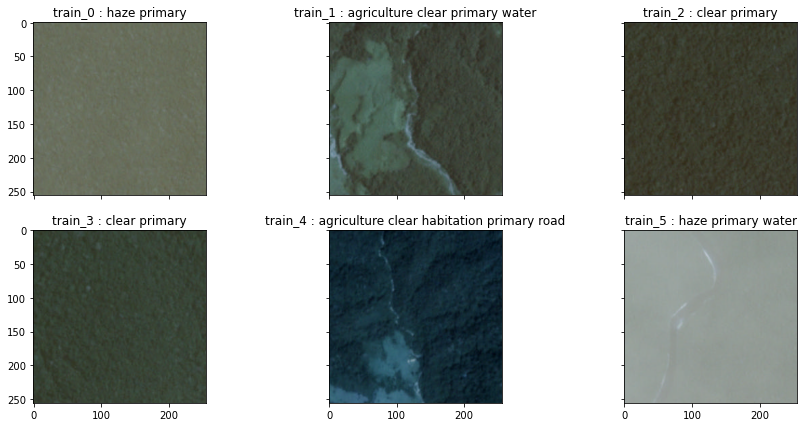

In [7]:
# View some of the train images

new_style = {'grid': False}
plt.rc('axes', **new_style)

fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)
i = 0

for name, label in train[:6].values:
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(name))
    ax[i // 3, i % 3].imshow(cv2.resize(img, (256, 256)))
    ax[i // 3, i % 3].set_title('{} : {}'.format(name, label))
    i += 1

In [8]:
#Create a dictionary assigning a numerical value to each label

label_map = {i:j for j, i in enumerate(tag_list)}
label_map

{'haze': 0,
 'primary': 1,
 'agriculture': 2,
 'clear': 3,
 'water': 4,
 'habitation': 5,
 'road': 6,
 'cultivation': 7,
 'slash_burn': 8,
 'cloudy': 9,
 'partly_cloudy': 10,
 'conventional_mine': 11,
 'bare_ground': 12,
 'artisinal_mine': 13,
 'blooming': 14,
 'selective_logging': 15,
 'blow_down': 16}

In [9]:
# One hot encode the training labels. 
# Convert the images into pixels and resize them

gc.collect()

X_train, Y_train = [], []

for img, label in tqdm(train.values, miniters = 1000):
    target = np.zeros(len(tag_list))
    for tag in label.split(' '):
        target[label_map[tag]] = 1
    arr = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(img))
    
    X_train.append(cv2.resize(arr, (64,64)))
    Y_train.append(target)

100%|██████████| 40479/40479 [01:35<00:00, 423.55it/s]


In [10]:
# Convert the test images to pixels and resize them.
# Appending them to the same list X_test

gc.collect()

X_test=[]

for img, label in tqdm(sample_sub[:40669].values, miniters = 1000):
    arr = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img))
    X_test.append(cv2.resize(arr, (64,64)))
    
for img, label in tqdm(sample_sub[40669:].values, miniters = 1000):
    arr = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img))
    X_test.append(cv2.resize(arr, (64,64)))

100%|██████████| 20522/20522 [00:49<00:00, 418.65it/s]


In [11]:
gc.collect()

len(X_train), len(Y_train), len(X_test)

(40479, 40479, 61191)

### Pre-processing
Here, I am going to convert the lists `X_train`, `Y_train`, `X_test` to numpy arrays. After that, I will normalize the array.

In [12]:
seed = 1891

In [13]:
gc.collect()

x_train = np.array(X_train, np.float16)/255
y_train = np.array(Y_train, np.uint8)
x_test = np.array(X_test, np.float16)/255

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle=True, random_state=1)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(32383, 64, 64, 3) (32383, 17) (8096, 64, 64, 3) (8096, 17)


In [14]:
del(X_test, X_train, Y_train)

gc.collect()

20

In [15]:
yfull_test = []
yfull_train = []

x_train_, x_val_, y_train_, y_val_ = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

print(x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape)

(25906, 64, 64, 3) (25906, 17) (6477, 64, 64, 3) (6477, 17)


## Build a 5-layer CNN model

In [16]:
#Create a path to save the weights
kfold_weights_path = os.path.join('', 'weights_kfold_' + '.h5')

model = Sequential()
model.add(BatchNormalization(input_shape=(64, 64,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

        
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

In [17]:
epochs = 30
learn_rate = 0.0001
opt  = optimizers.Adam(lr=learn_rate)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]

In [18]:
model.fit(x=x_train_, y=y_train_, validation_data=(x_val_, y_val_), batch_size=128, verbose=2, epochs=epochs, callbacks=callbacks, shuffle=True)

Epoch 1/30
203/203 - 7s - loss: 0.6367 - accuracy: 0.1399 - val_loss: 0.5831 - val_accuracy: 0.8644
Epoch 2/30
203/203 - 6s - loss: 0.4476 - accuracy: 0.2301 - val_loss: 0.3721 - val_accuracy: 0.8644
Epoch 3/30
203/203 - 6s - loss: 0.2714 - accuracy: 0.3463 - val_loss: 0.2375 - val_accuracy: 0.6094
Epoch 4/30
203/203 - 6s - loss: 0.2009 - accuracy: 0.4353 - val_loss: 0.1924 - val_accuracy: 0.6636
Epoch 5/30
203/203 - 6s - loss: 0.1746 - accuracy: 0.4956 - val_loss: 0.1697 - val_accuracy: 0.2314
Epoch 6/30
203/203 - 6s - loss: 0.1615 - accuracy: 0.5528 - val_loss: 0.1620 - val_accuracy: 0.6435
Epoch 7/30
203/203 - 6s - loss: 0.1529 - accuracy: 0.5803 - val_loss: 0.1533 - val_accuracy: 0.4635
Epoch 8/30
203/203 - 6s - loss: 0.1473 - accuracy: 0.6239 - val_loss: 0.1440 - val_accuracy: 0.3679
Epoch 9/30
203/203 - 6s - loss: 0.1431 - accuracy: 0.6392 - val_loss: 0.1430 - val_accuracy: 0.6790
Epoch 10/30
203/203 - 6s - loss: 0.1402 - accuracy: 0.6623 - val_loss: 0.1370 - val_accuracy: 0.7298

In [19]:
p_val = model.predict(x_val_, batch_size=32, verbose=2)

print(fbeta_score(y_val_, np.array(p_val) > 0.2, beta=2, average='samples')) #Check the model performance on the validation set

203/203 - 1s
0.8927795880083771


In [20]:
del(x_train_, x_val_, y_train_, y_val_)

gc.collect()

2275

In [21]:
p_train = model.predict(x_train, batch_size =128, verbose=2) #save the training predictions
yfull_train.append(p_train)

p_test = model.predict(x_test, batch_size = 128, verbose=2) #save the test predictions
yfull_test.append(p_test)

253/253 - 2s
479/479 - 4s


In [22]:
len(p_test)

61191

In [23]:
result = np.array(p_test)

result = pd.DataFrame(result, columns = tag_list)
result = result.set_index(sample_sub.image_name)

In [24]:
result.head()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
image_name,,,,,,,,,,,,,,,,,
test_0,0.002840,0.999358,0.006526,0.995785,0.012072,0.001011,0.003208,0.003208,0.000123,0.000307,0.000782,0.000083,0.000399,0.000162,0.001743,0.000298,0.000207
test_1,0.003492,0.998796,0.017560,0.992103,0.008702,0.001837,0.003635,0.015341,0.001023,0.001088,0.003806,0.000358,0.001584,0.000461,0.016098,0.002302,0.002096
test_2,0.000856,0.999125,0.080250,0.001606,0.081536,0.005985,0.035868,0.021369,0.000457,0.000569,0.999085,0.000411,0.001445,0.000476,0.000269,0.000419,0.000242
test_3,0.008562,0.998680,0.137244,0.899651,0.029867,0.004344,0.011039,0.097727,0.001773,0.001151,0.076500,0.000511,0.003257,0.000840,0.004483,0.002031,0.001776
test_4,0.007889,0.666613,0.116637,0.011490,0.121556,0.017217,0.054313,0.017786,0.001168,0.225647,0.783716,0.002950,0.005709,0.002612,0.001529,0.001782,0.001072


## Making First Submission

In [25]:
preds = list()

for i in tqdm(range(len(result)), miniters=1000):
    a = result.iloc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    col = a.columns[0]
    a = a.loc[a[col] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:54<00:00, 532.82it/s]


In [26]:
sub_df = sample_sub
sub_df['tags'] = preds

In [27]:
sub_df.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary cloudy partly_cloudy


In [28]:
sub_df.to_csv('first_submission.csv', index=False)

## Designing a Better F-Beta score

In [ ]:
import numpy as np
from keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    f_beta_score = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    
    return f_beta_score

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(64, 64,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

        
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[fbeta])
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]

In [ ]:
model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=128, verbose=2, epochs=epochs, callbacks=callbacks, shuffle=True)

In [ ]:
p_val = model.predict(x_val, batch_size=32, verbose=2)

print(fbeta_score(y_val, np.array(p_val) > 0.2, beta=2, average='samples')) #Check the model performance on the validation set

In [ ]:
print(fbeta(y_val, np.array(p_val)))

In [ ]:
prediction = model.predict(x_test, batch_size = 128, verbose = 2)